# Data Augmentation

Pada lab sebelumnya, validation accuracy masih tertinggal dari training accuracy, hal ini merupakan tanda2 overfitting.

Untuk teach model supaya lebih robust ketika melihat pada data yang baru, kita akan meningkatkan size dan variasi dari dataset dengan data augmentation. Penambahan ukuran membuat model memiliki lebih banyak citra untuk training, penambahan variasi membantu model untuk memelih feature yang benar2 penting untuk klasifikasi sehingga dapat melakukan generalisasi dengan lebih baik

## Objectives



*   Augment the ASL dataset
*   Menggunakan augmented data untuk train model
*   Save model yang telah ditrain





## 1. Augment the ASL dataset

In [2]:
import tensorflow.keras as keras
import pandas as pd

# Load csv file kedalam dataframe
train_df = pd.read_csv("/content/sign_mnist_train.csv")
valid_df = pd.read_csv("/content/sign_mnist_valid.csv")

# extract label
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# extract image data
x_train = train_df.values
x_valid = valid_df.values

# Ubah nilai label (skalar) menjadi categorical
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape image data untuk convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [3]:
# membuat model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

Data Augmentation

Keras memiliki image augmentation class yang disebut ImageDataGenerator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10, #rotate image secara random dalam range(0-180 derajat)
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False, # tidak vertical flip secara random karena kita tidak expect tangan untuk vert flip
)

ImageDataGenerator dapat batches data sehingga model dapat ditrain pada random sample.

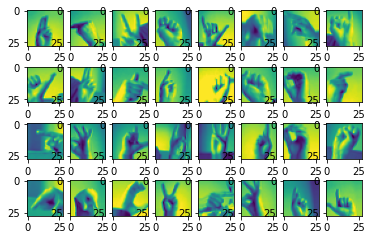

In [5]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
  image = x[i]
  ax.flatten()[i].imshow(np.squeeze(image))
plt.show()


In [6]:
# fitting data ke generator
datagen.fit(x_train)

In [7]:
# compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## 2. Train the Model

Ketika menggunakan image data generator denga keras, model train sedikit berbeda. Generator dapat menyuplai jumlah data yang tak terbatas untuk train, maka perlu menetapkan seberapa lama setiap epoch untuk berjalan.

In [8]:
model.fit(img_iter, epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # jumlah step sama seperti tidak menggunakan generator
          validation_data=(x_valid, y_valid))

Epoch 1/20
857/857 [==============================] - 109s 125ms/step - loss: 1.0479 - accuracy: 0.6651 - val_loss: 1.8956 - val_accuracy: 0.5325
Epoch 2/20
857/857 [==============================] - 106s 124ms/step - loss: 0.3052 - accuracy: 0.8960 - val_loss: 0.1789 - val_accuracy: 0.9435
Epoch 3/20
857/857 [==============================] - 108s 125ms/step - loss: 0.1965 - accuracy: 0.9327 - val_loss: 0.4526 - val_accuracy: 0.8369
Epoch 4/20
857/857 [==============================] - 106s 124ms/step - loss: 0.1422 - accuracy: 0.9536 - val_loss: 0.0953 - val_accuracy: 0.9706
Epoch 5/20
857/857 [==============================] - 106s 123ms/step - loss: 0.1268 - accuracy: 0.9587 - val_loss: 0.2282 - val_accuracy: 0.9322
Epoch 6/20
857/857 [==============================] - 106s 123ms/step - loss: 0.1100 - accuracy: 0.9647 - val_loss: 0.1212 - val_accuracy: 0.9601
Epoch 7/20
857/857 [==============================] - 106s 124ms/step - loss: 0.1011 - accuracy: 0.9675 - val_loss: 0.0227 -

Terlihat bahwa akurasi validasi dan akurasi training memiliki angka yang mirip, tidak terdapat gap yang jauh seperti lab sebelumnya. Hal ini menunjukkan bahwa model sudah tidak mengalami overfitting, sehingga bisa melakukan generalisasi dengan lebih baik dan membuat prediksi yang lebih baik pada data yang baru

## Save the Model

Model yang telah ditrain dapat disave kemudian dideploy untuk melakukan inference pada citra yang baru

In [9]:
model.save('asl_model')

INFO:tensorflow:Assets written to: asl_model/assets


# ASL Predictions

## Objectives



*   Load model yang sudah ditrain
*   Prepare images
*   Perform inference dengan citra baru





In [10]:
# load the model
from tensorflow import keras
model = keras.models.load_model('/content/asl_model')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

Karena image yang akan dilakukan prediksi memiliki resolusi yang lebih tinggi dan berwarna dari image yang ada di dataset yang digunakan model untuk training yang mana merupakan 28x28 images and grayscale. Kita perlu mengubah citra tersebut kedalam shape yang sesuai dengan citra dimana model ditrain. Citra yang digunakan untuk train model memiliki shape (27455, 28, 28, 1), 27455 citra dengan 28 by 28 pixels setiapnya dengan 1 color channel (grayscale)

In [12]:
# show image yang digunakan untuk prediksi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
  image = mpimg.imread(image_path)
  print(image.shape)
  plt.imshow(image, cmap='gray')

(186, 188, 4)


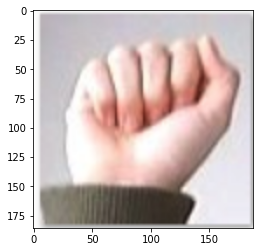

In [13]:
show_image('/content/a.png')

In [15]:
# ubah citra ke shape yang sesuai dengan input model
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
  image = image_utils.load_img(image_path, color_mode="grayscale",
                               target_size=(28,28))
  return image

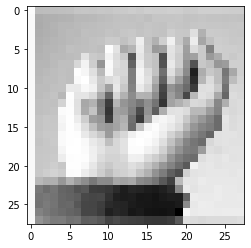

In [16]:
image = load_and_scale_image('/content/a.png')
plt.imshow(image, cmap='gray')

Sekarang citra sudah dalam 28x28 pixel grayscale. kita ubah citra kedalam shape (1, 28, 28, 1)

In [17]:
# convert citra ke format yang lebih mendasar (matriks of pixel value)
image = image_utils.img_to_array(image)

# reshape image
image = image.reshape(1, 28, 28, 1) # 1 citra dg 28x28 pixel dg 1 color channel

# normalize image data
image = image / 255

Setelah preprocessing image, saatnya melakukan prediksi

In [18]:
prediction = model.predict(image)
print(prediction)

[[9.9963963e-01 2.5888468e-29 3.8345213e-32 1.5271506e-36 1.6568051e-25
  3.8187232e-19 0.0000000e+00 2.4219606e-29 9.8660846e-14 1.5160660e-26
  2.9439010e-25 1.4317600e-14 3.6038316e-04 5.2736310e-35 3.2165390e-31
  0.0000000e+00 0.0000000e+00 1.0463297e-18 4.6643678e-32 1.8205230e-36
  2.2623852e-30 7.2057231e-13 1.5859871e-29 4.2675978e-09]]


Hasil prediksi diatas berupa probabilitas untuk setiap kelas. Kita perlu mencari kelas dengan nilai probabilitas paling tinggi

In [19]:
import numpy as np
np.argmax(prediction)

0

In [20]:
# mapping index prediction array, ke koresponding huruf
alphabet = "abcdefghiklmnopqrstuvwxy" #exclude j and z
dictionary = {}
for i in range(24):
  dictionary[i] = alphabet[i]
dictionary

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'k',
 10: 'l',
 11: 'm',
 12: 'n',
 13: 'o',
 14: 'p',
 15: 'q',
 16: 'r',
 17: 's',
 18: 't',
 19: 'u',
 20: 'v',
 21: 'w',
 22: 'x',
 23: 'y'}

In [21]:
dictionary[np.argmax(prediction)]

'a'

Put it all Together

In [22]:
def predict_letter(image_path):
  # Show image
  show_image(image_path)

  #load and scale image
  image = load_and_scale_image(image_path)

  # convert to array
  image = image_utils.img_to_array(image)

  # reshape image
  image = image.reshape(1, 28, 28, 1)

  # normalize image
  image = image / 255

  # make prediction
  prediction = model.predict(image)

  # convert prediction to letter
  predicted_letter = dictionary[np.argmax(prediction)]
  return predicted_letter


(186, 188, 4)
a


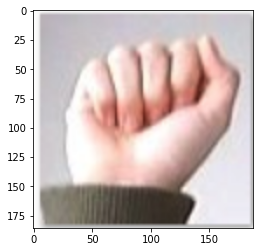

In [23]:
print(predict_letter('/content/a.png'))